In [ ]:
!pip install --upgrade tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada ResNet50 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import regularizers

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
conv_base  = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/Database3.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Database3/Train/nv/ISIC_0026937.jpg  
  inflating: Database3/Train/nv/ISIC_0026939.jpg  
  inflating: Database3/Train/nv/ISIC_0026942.jpg  
  inflating: Database3/Train/nv/ISIC_0026943.jpg  
  inflating: Database3/Train/nv/ISIC_0026945.jpg  
  inflating: Database3/Train/nv/ISIC_0026946.jpg  
  inflating: Database3/Train/nv/ISIC_0026949.jpg  
  inflating: Database3/Train/nv/ISIC_0026971.jpg  
  inflating: Database3/Train/nv/ISIC_0026973.jpg  
  inflating: Database3/Train/nv/ISIC_0026974.jpg  
  inflating: Database3/Train/nv/ISIC_0026977.jpg  
  inflating: Database3/Train/nv/ISIC_0026979.jpg  
  inflating: Database3/Train/nv/ISIC_0026980.jpg  
  inflating: Database3/Train/nv/ISIC_0026982.jpg  
  inflating: Database3/Train/nv/ISIC_0026983.jpg  
  inflating: Database3/Train/nv/ISIC_0026985.jpg  
  inflating: Database3/Train/nv/ISIC_0026994.jpg  
  inflating: Database3/Train/nv/ISIC_0026997.jpg  
  inflating: Database

Ajustando los datos de la BD


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

train_dataset = image_dataset_from_directory(
    'Database3/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'Database3/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Database3/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)


Found 5284 files belonging to 4 classes.
Found 2263 files belonging to 4 classes.
Found 1884 files belonging to 4 classes.


La fase de entrenamiento podrá alterar los pesos de las 3 últimas capas

In [ ]:
#conv_base.trainable = False
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

Transformaciones para expandir las imágenes y definición de la arquitectura


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x) #training= false
x = layers.Flatten()(x)
x = layers.Dense(385, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                             

Fijar los hiperparámetros y entrenar la red

In [ ]:
conv_base.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        #filepath=checkpoint_filepath,
        filepath='model20-12-2020_dp03031024.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=1,
        save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=1000,  #30
    batch_size=32,
    validation_data=validation_dataset,
    callbacks=callbacks_list)

Epoch 1/1000
166/166 [==============================] - ETA: 0s - loss: 35.0460 - accuracy: 0.3989
Epoch 1: val_accuracy improved from -inf to 0.59346, saving model to model20-12-2020_dp03031024.h5
166/166 [==============================] - 37s 126ms/step - loss: 35.0460 - accuracy: 0.3989 - val_loss: 34.2441 - val_accuracy: 0.5935 - lr: 1.0000e-05
Epoch 2/1000
165/166 [============================>.] - ETA: 0s - loss: 34.1791 - accuracy: 0.5295
Epoch 2: val_accuracy improved from 0.59346 to 0.63367, saving model to model20-12-2020_dp03031024.h5
166/166 [==============================] - 19s 113ms/step - loss: 34.1800 - accuracy: 0.5295 - val_loss: 33.6473 - val_accuracy: 0.6337 - lr: 1.0000e-05
Epoch 3/1000
165/166 [============================>.] - ETA: 0s - loss: 33.4619 - accuracy: 0.5843
Epoch 3: val_accuracy improved from 0.63367 to 0.64781, saving model to model20-12-2020_dp03031024.h5
166/166 [==============================] - 19s 113ms/step - loss: 33.4617 - accuracy: 0.5840 -

Visualizando la pérdida y el accuracy durante el entrenamiento


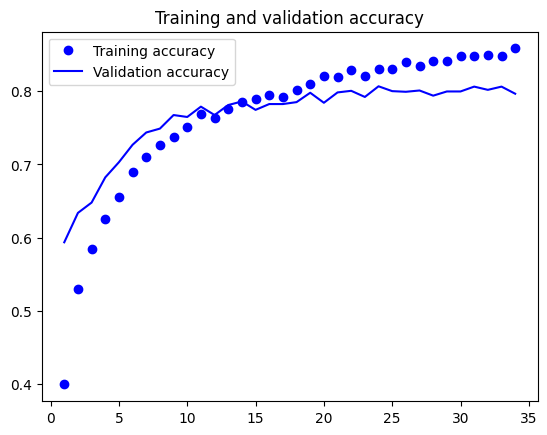

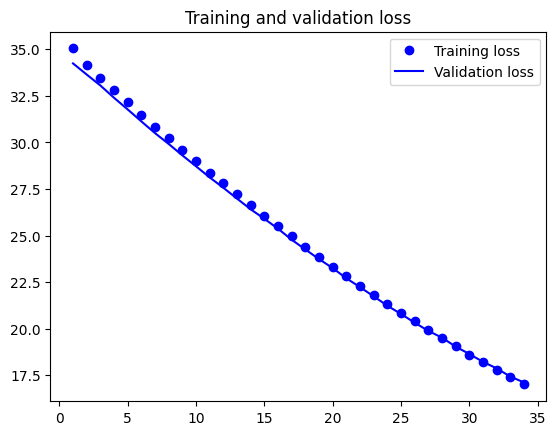

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
print("--------------------------Test Results------------------------")
test_scores = model.evaluate(test_dataset, verbose=2)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

--------------------------Test Results------------------------
59/59 - 5s - loss: 17.1087 - accuracy: 0.7951 - 5s/epoch - 88ms/step
Test Loss: 17.10866928100586
Test Accuracy: 0.7951167821884155


### Matriz de confusión y métricas relevantes

In [ ]:
import numpy as np

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 1s 929ms/step


Hago el siguiente procedimiento porque en el código anterior los últimos
vectores que se agregan en las listas no es del mismo tamaño que los que se venían agregando,
entonces extraigo eso últimos vectores para agregar sus elementos al final.

Además, para las siguientes matrices hago lo mismo

In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[ 202   36   43    8]
 [  12  481   89   34]
 [   5   30  524   65]
 [  15  139  270 3331]]


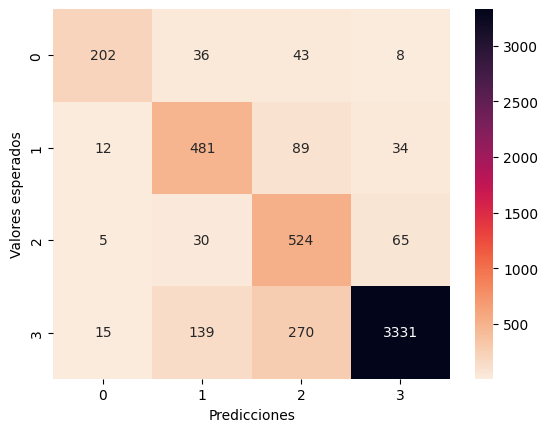

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       289
           1       0.70      0.78      0.74       616
           2       0.57      0.84      0.68       624
           3       0.97      0.89      0.93      3755

    accuracy                           0.86      5284
   macro avg       0.77      0.80      0.78      5284
weighted avg       0.88      0.86      0.87      5284



In [ ]:
#predicciones_test = model.predict(images_test)
import matplotlib.pyplot as plt
import seaborn as sns

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 28ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[  74   19   20   10]
 [   5  166   60   33]
 [   5   28  178   56]
 [   9   75  140 1385]]


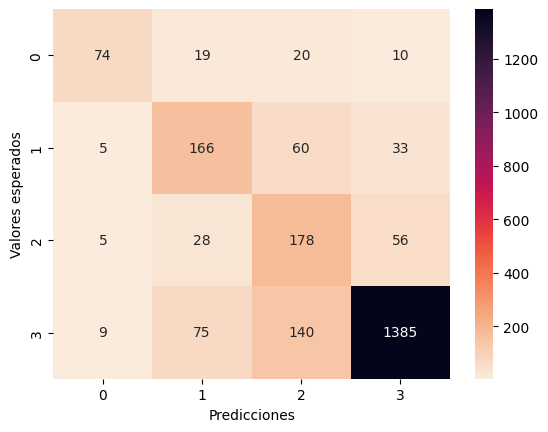

              precision    recall  f1-score   support

           0       0.80      0.60      0.69       123
           1       0.58      0.63      0.60       264
           2       0.45      0.67      0.54       267
           3       0.93      0.86      0.90      1609

    accuracy                           0.80      2263
   macro avg       0.69      0.69      0.68      2263
weighted avg       0.83      0.80      0.81      2263



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 27ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[  58   14   23    7]
 [   8  138   47   26]
 [   1   20  150   51]
 [   5   63  121 1152]]


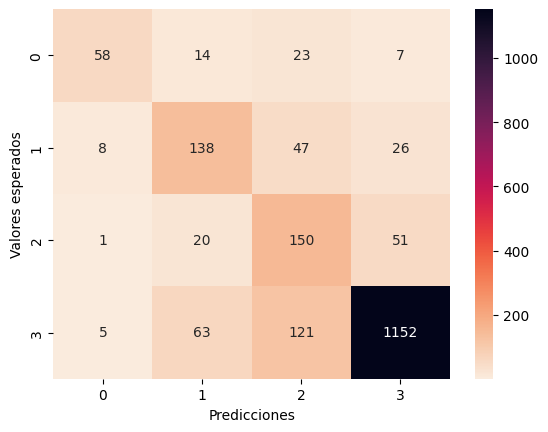

              precision    recall  f1-score   support

           0       0.81      0.57      0.67       102
           1       0.59      0.63      0.61       219
           2       0.44      0.68      0.53       222
           3       0.93      0.86      0.89      1341

    accuracy                           0.80      1884
   macro avg       0.69      0.68      0.68      1884
weighted avg       0.83      0.80      0.81      1884



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

### Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
import tensorflow as tf
import pathlib

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
#tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir = pathlib.Path(".")
tflite_model_file = tflite_models_dir/"model_ResNet50.tflite"
tflite_model_file.write_bytes(tflite_model)

320480548

In [ ]:
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]

In [ ]:
# tflite_models_dir = pathlib.Path(".")
# tflite_fp16_model = converter.convert()
# tflite_model_fp16_file = tflite_models_dir/"model_VGG16_quant_f16.tflite"
# tflite_model_fp16_file.write_bytes(tflite_fp16_model)